## Import

In [1]:
# Import internal modules
import os.path
import joblib
import time
from typing import List, Set, Dict, Tuple, Optional

# Import 3rd party modules
import pandas as pd
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report, accuracy_score, recall_score, roc_auc_score, confusion_matrix, plot_confusion_matrix, plot_precision_recall_curve
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import StratifiedKFold
from imblearn.under_sampling import RandomUnderSampler

## Load dataset

In [2]:
df = pd.read_csv(os.path.join("assets","data","thread_csv_all.csv"))
df.head()

,noise_db,machine_type,model_id,sound,sound_path,target,spect_mean,spect_min,spect_max,spect_std,...,zero_crossing_rate_max,zero_crossing_rate_std,d_harmonic_mean,d_harmonic_min,d_harmonic_max,d_harmonic_std,d_percussive_mean,d_percussive_min,d_percussive_max,d_percussive_std
0,-6,slider,0,00000000.wav,assets\sounds\-6_dB_slider\slider\id_00\abnorm...,abnormal,0.107133,1.922508e-11,8.000317,0.286640,...,0.125488,0.015289,0.059173,1.413419e-12,7.861723,0.217199,0.047960,1.447360e-11,2.427006,0.102428
1,-6,slider,0,00000001.wav,assets\sounds\-6_dB_slider\slider\id_00\abnorm...,abnormal,0.091550,1.239772e-10,11.825641,0.306949,...,0.122559,0.022209,0.051675,1.856747e-13,11.707416,0.261016,0.039876,7.817087e-11,2.639281,0.086876
2,-6,slider,0,00000002.wav,assets\sounds\-6_dB_slider\slider\id_00\abnorm...,abnormal,0.114412,2.546376e-10,8.061798,0.300529,...,0.107422,0.013853,0.061442,5.859085e-13,7.840732,0.220184,0.052971,7.954731e-11,2.856351,0.114448
3,-6,slider,0,00000003.wav,assets\sounds\-6_dB_slider\slider\id_00\abnorm...,abnormal,0.108589,6.224236e-11,7.651740,0.277428,...,0.125488,0.012602,0.064017,1.636899e-13,7.523073,0.240022,0.044573,2.057399e-11,1.847202,0.077006
4,-6,slider,0,00000004.wav,assets\sounds\-6_dB_slider\slider\id_00\abnorm...,abnormal,0.107343,9.855214e-12,7.804570,0.287012,...,0.119141,0.010417,0.064301,1.400486e-13,7.756195,0.248836,0.043042,4.824911e-12,2.022621,0.079337


In [3]:
df.shape

(54057, 70)

## Feature engineering 

In [4]:
# Replace abnormal by 1, normal by 0
df.target = df.target.apply(lambda x: 1 if x == "abnormal" else 0)

## Feature selection

**Notes**: 
We analyzed the correlation matrix and computed the feature importances.
Based on our analysis, we selected the columns below.
However, our current best model works better without this feature selection.

selected_cols = [
"rms_std",
"rms_max",
"d_percussive_max",
"d_percussive_std",
"chroma_min",
"mel_spect_std",
"cent_std",
"tonnetz_mean",
"zero_crossing_rate_std",
"spect_mean",
"tonnetz_std",
"roll_off_max",
"tonnetz_max",
"chroma_cq_mean",
"chroma_cens_max",
"contrast_min",
"chroma_mean",
"spec_bw_mean",
"tonnetz_min",
"zero_crossing_rate_mean",
]

In [5]:
# Select numeric columns
selected_cols = df.select_dtypes(include="number").columns.tolist()

# Drop noise_db and model_id columns
selected_cols.remove("noise_db")
selected_cols.remove("model_id")
selected_cols.remove("target")

X = df[selected_cols]
y = df.target

print("\n============================================================")
print(f"              Features                                       ")
print("============================================================")
print(selected_cols)


              Features                                       
['spect_mean', 'spect_min', 'spect_max', 'spect_std', 'mel_spect_mean', 'mel_spect_min', 'mel_spect_max', 'mel_spect_std', 'chroma_mean', 'chroma_min', 'chroma_max', 'chroma_std', 'chroma_cq_mean', 'chroma_cq_min', 'chroma_cq_max', 'chroma_cq_std', 'chroma_cens_mean', 'chroma_cens_min', 'chroma_cens_max', 'chroma_cens_std', 'mfcc_mean', 'mfcc_min', 'mfcc_max', 'mfcc_std', 'rms_mean', 'rms_min', 'rms_max', 'rms_std', 'cent_mean', 'cent_min', 'cent_max', 'cent_std', 'spec_bw_mean', 'spec_bw_min', 'spec_bw_max', 'spec_bw_std', 'contrast_mean', 'contrast_min', 'contrast_max', 'contrast_std', 'flatness_mean', 'flatness_min', 'flatness_max', 'flatness_std', 'roll_off_mean', 'roll_off_min', 'roll_off_max', 'roll_off_std', 'tonnetz_mean', 'tonnetz_min', 'tonnetz_max', 'tonnetz_std', 'zero_crossing_rate_mean', 'zero_crossing_rate_min', 'zero_crossing_rate_max', 'zero_crossing_rate_std', 'd_harmonic_mean', 'd_harmonic_min', 'd_harmon

In [6]:
# Select features X and target variable y
X = df[selected_cols]
y = df.target

## Split dataset

In [7]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42,
                                                    stratify=y
                                                   )

print(f"X_train: {X_train.shape}   - y_train: {y_train.shape}")
print(f"X_test:  {X_test.shape}    - y_train: {y_test.shape}")

X_train: (43245, 64)   - y_train: (43245,)
X_test:  (10812, 64)    - y_train: (10812,)


## Undersampling/Oversampling

In [8]:
# Instantiate Undersample object
undersample = RandomUnderSampler(sampling_strategy='auto')

# Apply the transform on the training set
X_train, y_train = undersample.fit_resample(X_train, y_train)

## Models
**Notes**:
SVC and LogisticRegression removed 
as they perform poorly most of the time

In [9]:
# 1. Create pipelines
pipe_random_forest = make_pipeline(RandomForestClassifier(random_state=5))
pipe_decision_tree = make_pipeline(DecisionTreeClassifier(random_state=5))
pipe_balanced_random_forest = make_pipeline(BalancedRandomForestClassifier(random_state=5))
pipe_xgboost_classifier = make_pipeline(XGBClassifier())


# 2. GridSearchCV for each pipeline: to train models with different parameters
# and get the best models (for each pipeline) with the best parameters
scoring = {'recall_score': "recall", 'roc_auc_score': 'roc_auc'}

cv_stratified = StratifiedKFold(n_splits=10)

## 2.1 Define grid search parameters
grid_params_random_forest = {
    'randomforestclassifier__n_estimators': [90, 100, 110],
    'randomforestclassifier__criterion': ['gini', 'entropy']
}

grid_params_decision_tree = {
    'decisiontreeclassifier__criterion': ['gini', 'entropy']
}

grid_params_balanced_random_forest = {
    'balancedrandomforestclassifier__n_estimators': [90, 100, 110],
    'balancedrandomforestclassifier__criterion': ['gini', 'entropy']
}

grid_params_xgboost_classifier = {
    'xgbclassifier__max_depth': [10, 11]
}

## 2.2 Instantiate grid searches
### set n_jobs to -1 to use all processors
n_jobs: int = 3

grid_random_forest = GridSearchCV(
    estimator=pipe_random_forest,
    param_grid=grid_params_random_forest,
    scoring=scoring,
    refit='recall_score',
    cv=cv_stratified,
    n_jobs=n_jobs
)

grid_decision_tree = GridSearchCV(
    estimator=pipe_decision_tree,
    param_grid=grid_params_decision_tree,
    scoring=scoring,
    refit='recall_score',
    cv=cv_stratified,
    n_jobs=n_jobs
)

grid_balanced_random_forest = GridSearchCV(
    estimator=pipe_balanced_random_forest,
    param_grid=grid_params_balanced_random_forest,
    scoring=scoring,
    refit='recall_score',
    cv=cv_stratified,
    n_jobs=n_jobs
)

grid_xgboost_classifier = GridSearchCV(
    estimator=pipe_xgboost_classifier,
    param_grid=grid_params_xgboost_classifier,
    scoring=scoring,
    refit='recall_score',
    cv=cv_stratified,
    n_jobs=n_jobs
)

In [10]:
## 2.3 Create dict of grids
grids: Dict[str, GridSearchCV] = {
    "random_forest": grid_random_forest,
    "decision_tree": grid_decision_tree,
    "balanced_random_forest": grid_balanced_random_forest,
    "xgboost_classifier": grid_xgboost_classifier
}

# 2.4 Keep track of the best accuracy score
best_recall = 0.0
best_model = None
best_model_name = ""    
    
## 2.4 Fit the grids to the training set
for grid_name, grid in grids.items():
    start_time = time.time()
    print("\n============================================================")
    print(f"              Fitting training with {grid_name}              ")
    print("============================================================")
    grid.fit(X_train, y_train)
    print(f'\nbest params: {grid.best_params_}')
    print(f'\nbest training recall: {grid.best_score_}')
    
    # Print scores of all the scorers
    print(f'\nbest scorer:{grid.cv_results_}')

    # Predict on test set with best parameters
    y_pred = grid.predict(X_test)
    recall_score_value = recall_score(y_test, y_pred)
    print(f'\nrecall_score on test set with best parameters: {recall_score_value}')

    # Update the best model
    if recall_score_value > best_recall:
        best_recall = recall_score_value
        best_model = grid
        best_model_name = grid_name
    
    # Print time to select best model within a grid
    end_time = time.time()
    diff_time_m = (end_time - start_time)/60
    print(f"\nTime to select best {grid_name}: {diff_time_m:.2f} minutes")
    
print("\n************************************************************")
print("                       Conclusion                             ")
print(f"Model with best recall on test set: {best_model_name}")


              Fitting training with random_forest              

best params: {'randomforestclassifier__criterion': 'entropy', 'randomforestclassifier__n_estimators': 110}

best training recall: 0.8553030303030302

best scorer:{'mean_fit_time': array([ 6.85884993,  7.63992386,  8.43007426,  9.19563749, 10.09470711,
       11.14101684]), 'std_fit_time': array([0.06883615, 0.06003875, 0.03910231, 0.11502562, 0.11795867,
       0.20161574]), 'mean_score_time': array([0.05168059, 0.05609145, 0.06094844, 0.04908848, 0.05412867,
       0.05920415]), 'std_score_time': array([0.00170317, 0.0011075 , 0.00277444, 0.00050716, 0.00074462,
       0.00193247]), 'param_randomforestclassifier__criterion': masked_array(data=['gini', 'gini', 'gini', 'entropy', 'entropy',
                   'entropy'],
             mask=[False, False, False, False, False, False],
       fill_value='?',
            dtype=object), 'param_randomforestclassifier__n_estimators': masked_array(data=[90, 100, 110, 90, 100, 110]

/Users/derrickvanfrausum/anaconda3/envs/mimii/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:54:36] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.

best params: {'xgbclassifier__max_depth': 11}

best training recall: 0.8852272727272726

best scorer:{'mean_fit_time': array([15.98435018, 16.37954748]), 'std_fit_time': array([0.23803271, 2.37471939]), 'mean_score_time': array([0.0282187 , 0.02947934]), 'std_score_time': array([0.00874289, 0.00944856]), 'param_xgbclassifier__max_depth': masked_array(data=[10, 11],
             mask=[False, False],
       fill_value='?',
            dtype=object), 'params': [{'xgbclassifier__max_depth': 10}, {'xgbclassifier__max_depth': 11}], 'split0_test_recall_score': array([0.89141414, 0.91287879]), 'split1_test_recall_score': array([0.88383838, 0.89141414]), 'split2_test_recall_score': array([0.89520202, 0.88636364]), 'split3_test_recall_score': arra

In [11]:
best_model.cv_results_

{'mean_fit_time': array([15.98435018, 16.37954748]),
 'std_fit_time': array([0.23803271, 2.37471939]),
 'mean_score_time': array([0.0282187 , 0.02947934]),
 'std_score_time': array([0.00874289, 0.00944856]),
 'param_xgbclassifier__max_depth': masked_array(data=[10, 11],
              mask=[False, False],
        fill_value='?',
             dtype=object),
 'params': [{'xgbclassifier__max_depth': 10},
  {'xgbclassifier__max_depth': 11}],
 'split0_test_recall_score': array([0.89141414, 0.91287879]),
 'split1_test_recall_score': array([0.88383838, 0.89141414]),
 'split2_test_recall_score': array([0.89520202, 0.88636364]),
 'split3_test_recall_score': array([0.87121212, 0.86489899]),
 'split4_test_recall_score': array([0.87373737, 0.87752525]),
 'split5_test_recall_score': array([0.88257576, 0.89393939]),
 'split6_test_recall_score': array([0.88636364, 0.88005051]),
 'split7_test_recall_score': array([0.88636364, 0.89141414]),
 'split8_test_recall_score': array([0.88888889, 0.87752525]),
 

In [12]:
## 2.5 Save the best grid search pipeline to joblib file
filepath = os.path.join("assets","data","best_model.joblib")
joblib.dump(best_model, filepath, compress=1)
print(f"Best model ({best_model_name}) is saved")

## 2.6 Load the model
loaded_model = joblib.load(filepath) 

print(loaded_model)
print("Best parameters: loaded_model.best_params_")
print(classification_report(y_test, loaded_model.predict(X_test)))

Best model (xgboost_classifier) is saved
GridSearchCV(cv=StratifiedKFold(n_splits=10, random_state=None, shuffle=False),
             estimator=Pipeline(steps=[('xgbclassifier',
                                        XGBClassifier(base_score=None,
                                                      booster=None,
                                                      colsample_bylevel=None,
                                                      colsample_bynode=None,
                                                      colsample_bytree=None,
                                                      gamma=None, gpu_id=None,
                                                      importance_type='gain',
                                                      interaction_constraints=None,
                                                      learning_rate=None,
                                                      max_delta_step=None,
                                                      max_de.

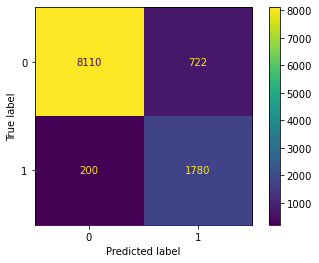

In [13]:
# Plot confusion matrix
plot_confusion_matrix(loaded_model, X_test, y_test)

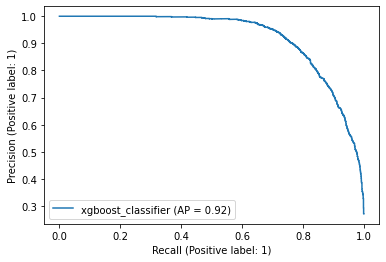

In [14]:
# Plot precision-recall-curve
plot_precision_recall_curve(loaded_model, X_test, y_test, name = best_model_name)